In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = None))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 100, Accuracy: 0.8148148148148148, Loss: 0.5978821648491753
Checkpoint 200, Accuracy: 0.8148148148148148, Loss: 0.5978821648491753
Checkpoint 300, Accuracy: 0.8148148148148148, Loss: 0.5978821648491753
Checkpoint 400, Accuracy: 0.8148148148148148, Loss: 0.5978821648491753
Checkpoint 500, Accuracy: 0.8148148148148148, Loss: 0.5978821648491753


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.90273666 0.07254582 0.02471756]
[1. 0. 0.] <-> [0.9066337  0.08940749 0.00395886]
[1. 0. 0.] <-> [0.9266005  0.06371526 0.0096842 ]
[0. 1. 0.] <-> [0.9716242  0.02362514 0.00475067]
[1. 0. 0.] <-> [0.9256786  0.0481284  0.02619301]
[0. 1. 0.] <-> [0.81851304 0.1793321  0.00215484]
[1. 0. 0.] <-> [0.7806361  0.11925531 0.10010864]
[1. 0. 0.] <-> [0.9024312  0.08783378 0.00973501]
[0. 0. 1.] <-> [0.7671039  0.03004522 0.20285085]
[0. 0. 1.] <-> [0.63757896 0.04705461 0.31536642]
[1. 0. 0.] <-> [0.9586838  0.03227051 0.0090457 ]
[1. 0. 0.] <-> [0.8596695  0.13450561 0.00582489]
[0. 1. 0.] <-> [0.8110461  0.18680236 0.00215149]
[1. 0. 0.] <-> [0.7217479  0.25684708 0.02140507]
[1. 0. 0.] <-> [0.9216969  0.06487131 0.01343175]
[1. 0. 0.] <-> [0.9311673  0.06072677 0.00810598]
[1. 0. 0.] <-> [0.88321936 0.1062053  0.01057534]
[1. 0. 0.] <-> [0.96152925 0.02919278 0.00927798]
[1. 0. 0.] <-> [0.8761304  0.11322924 0.01064037]
[0. 0. 1.] <-> [0.48680317 0.3007733  0.21242358]


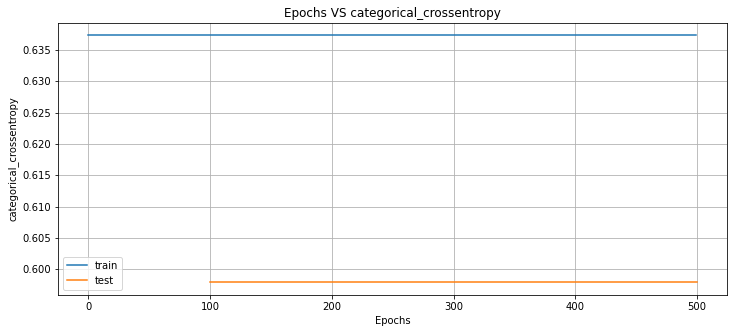

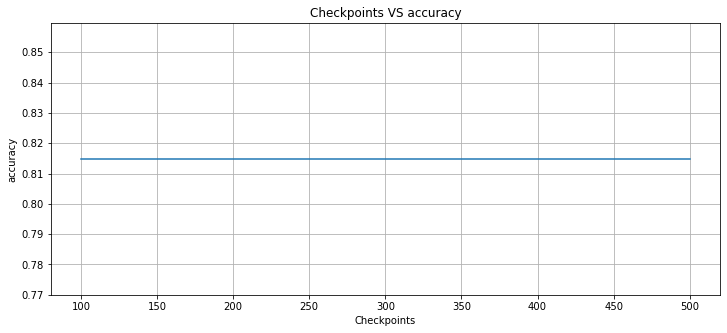

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8148148148148148, 'mean_square_error': 0.3814879714886389, 'categorical_crossentropy': 0.5978821648491753, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 30, 'tn_hit': 0, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 14}}, 'checkpoint': 100} 


{'accuracy': 0.8148148148148148, 'mean_square_error': 0.3814879714886389, 'categorical_crossentropy': 0.5978821648491753, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 30, 'tn_hit': 0, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 14}}, 'checkpoint': 200} 


{'accuracy': 0.8148148148148148, 'mean_square_error': 0.3814879714886389, 'categorical_crossentropy': 0.5978821648491753, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 30, 'tn_hit': 0, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 94, 'fn_hi

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[-1.25480182 -1.26872885  0.84883876  0.00491076 -2.89109123]
 bias: 1.470202514970632

Neuron 1: weights:
[-2.24927807  2.93292655  0.72465862  2.89687581 -1.3867399 ]
 bias: -1.9145343882618584

Neuron 2: weights:
[-1.79415     1.07734158  2.61492297 -0.22684836  0.92668999]
 bias: 0.7448411187220385

Neuron 3: weights:
[-0.27246737 -1.90670774 -2.35136983  0.48121593  2.67550736]
 bias: -2.886583300373829

$
Layer 2
Neuron 0: weights:
[-0.39374595  0.9109447  -1.63278694 -1.59108001]
 bias: 2.2017980121104133

Neuron 1: weights:
[ 1.27320331 -0.14337783  1.37956192  0.01555023]
 bias: -2.8837969070621705

Neuron 2: weights:
[-0.52387763 -0.32022177 -1.5146293   2.5042994 ]
 bias: -2.4993398857751616

$

